In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

Mounted at /content/drive


In [ ]:
#/content/drive/MyDrive/Colab Notebooks/

In [2]:
noisy_imgs1, noisy_imgs2 = torch.load('train_data.pkl') # 50000 x 3 x 32 x 32
val_noisy, val_clean = torch.load('val_data.pkl')

In [ ]:
'''def psnr(denoised, ground_truth):
  mse = torch.mean((denoised - ground_truth) ** 2)
  return -10*torch.log10(mse + 10 ** -8)
  '''

'def psnr(denoised, ground_truth):\n  mse = torch.mean((denoised - ground_truth) ** 2)\n  return -10*torch.log10(mse + 10 ** -8)\n  '

In [3]:
def train_model_torch(model, train_input, train_target, criterion, optimizer, mini_batch_size=1, epochs=500):
    for e in range(epochs):
        print(f"Epoch: {e}")
        avg_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size)) * 255
            # print(f"Torch Output: {output}")
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            # print(f"Torch Loss: {loss}")
            avg_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(avg_loss / (train_input.size(0) // mini_batch_size))
        print(validate(model, val_noisy.float(), val_clean.float()))


def psnr(x, y, max_range=255):
    assert x.shape == y.shape and x.ndim == 4
    return 20 * torch.log10(torch.tensor(max_range)) - 10 * torch.log10(((x - y) ** 2).mean((1, 2, 3))).mean()

def validate(model, noise_img, ground_truth):
    psnr_tot = 0
    for i in range(noise_img.size(0)):
        denoised = model.forward(noise_img[i].view(1, 3, 32, 32)) * 255
        psnr_val = psnr(denoised, ground_truth[i].unsqueeze(0)).item()
        psnr_tot += psnr_val
    psnr_tot /= noise_img.size(0)
    return psnr_tot

In [4]:
class LeanerModel(torch.nn.Module):
    def __init__(self, transposed_conv=False):
        super().__init__()
        self.main = torch.nn.Sequential(torch.nn.Conv2d(3, 32, kernel_size=(3, 3), padding=1), torch.nn.ReLU(),                
                             torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=1), torch.nn.ReLU(),
                             #torch.nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1), torch.nn.ReLU(),
                             torch.nn.UpsamplingNearest2d(scale_factor=2), torch.nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1), torch.nn.ReLU(),
                             torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(4, 4) , padding=1), torch.nn.ReLU(),
                             torch.nn.UpsamplingNearest2d(scale_factor=2), torch.nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1), torch.nn.ReLU(),
                             torch.nn.UpsamplingNearest2d(scale_factor=2), torch.nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1))
                  #what does linear activation mean (output unchanged?)
        self.sig = torch.nn.Sigmoid()
    def forward(self, x):
      input = x.clone()
      x = self.main(x)
      #x = input - x
      x = self.sig(x)
      return x

class LeanerModel2(torch.nn.Module):
    def __init__(self, transposed_conv=False):
        super().__init__()
        self.main = torch.nn.Sequential(                
                             torch.nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=1), torch.nn.ReLU(),
                             torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=1), torch.nn.ReLU(),
                             #torch.nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1), torch.nn.ReLU(),
                             torch.nn.UpsamplingNearest2d(scale_factor=2), torch.nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1), torch.nn.ReLU(),
                             #torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(4, 4) , padding=1), torch.nn.ReLU(),
                             #torch.nn.UpsamplingNearest2d(scale_factor=2), torch.nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1), torch.nn.ReLU(),
                             torch.nn.UpsamplingNearest2d(scale_factor=2), torch.nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1))
                  #what does linear activation mean (output unchanged?)
        self.sig = torch.nn.Sigmoid()
    def forward(self, x):
      input = x.clone()
      x = self.main(x)
      x = self.sig(x)
      x = input - x
      x = self.main(x)
      return x

In [4]:
device = "cuda"
noisy_imgs1 = noisy_imgs1.float().to(device)
noisy_imgs2 = noisy_imgs2.float().to(device)
val_noisy = val_noisy.float().to(device)
val_clean = val_clean.float().to(device)
model = torch.nn.Sequential(torch.nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=1), torch.nn.ReLU(),
                             torch.nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=1), torch.nn.ReLU(),
                             torch.nn.UpsamplingNearest2d(scale_factor=2), torch.nn.Conv2d(16, 16, kernel_size=(3, 3), padding='same'),torch.nn.ReLU(),
                             torch.nn.UpsamplingNearest2d(scale_factor=2), torch.nn.Conv2d(16, 3, kernel_size=(3, 3), padding='same'), torch.nn.Sigmoid())

model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer2 = torch.optim.SGD(model.parameters(), lr=0.0000005, momentum=0.8)
train_model_torch(model, noisy_imgs1, noisy_imgs2, criterion, optimizer2, epochs=20, mini_batch_size=250)





Epoch: 0
tensor(3627.8149, grad_fn=<DivBackward0>)
15.603350317001343
Epoch: 1
tensor(2561.7578, grad_fn=<DivBackward0>)
15.945690620422363
Epoch: 2
tensor(2284.3218, grad_fn=<DivBackward0>)
16.64699786376953
Epoch: 3
tensor(2109.4548, grad_fn=<DivBackward0>)
17.501215461730958
Epoch: 4
tensor(1967.6748, grad_fn=<DivBackward0>)
17.748044052124023
Epoch: 5
tensor(1868.5648, grad_fn=<DivBackward0>)
17.94672483253479
Epoch: 6
tensor(1786.5629, grad_fn=<DivBackward0>)
18.121202724456786
Epoch: 7


KeyboardInterrupt: 

In [87]:
import matplotlib.pyplot as plt
import numpy as np

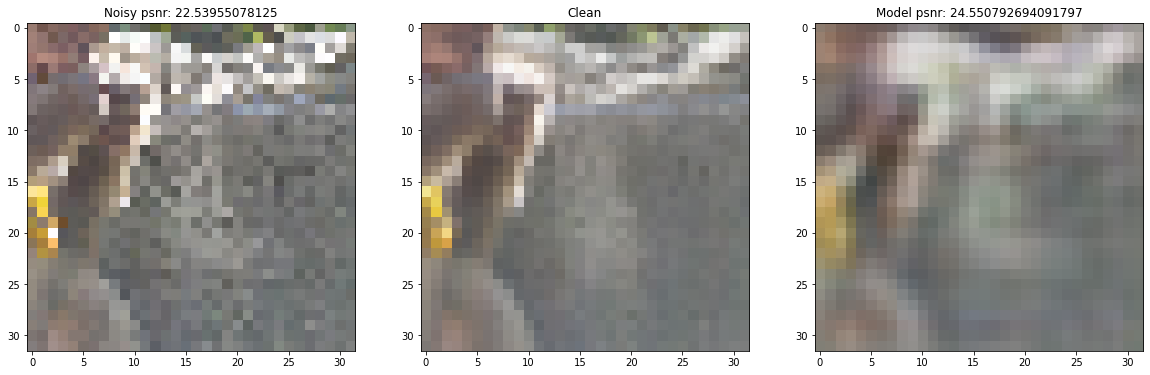

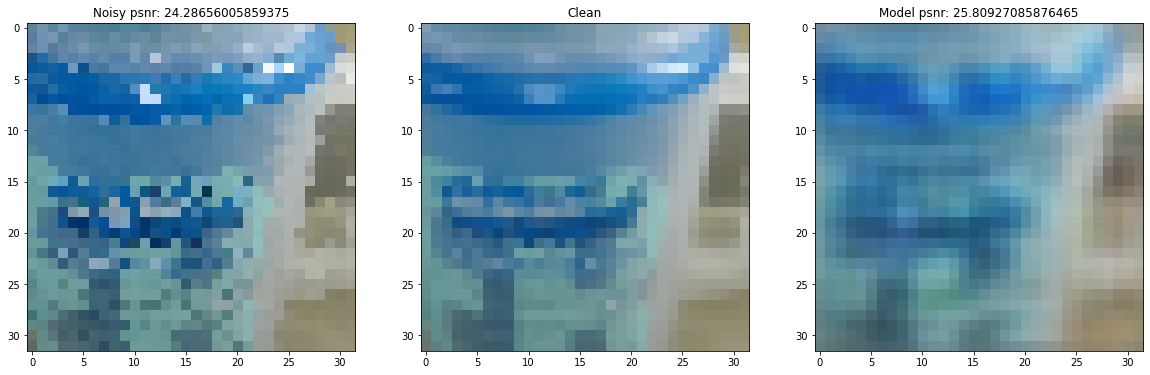

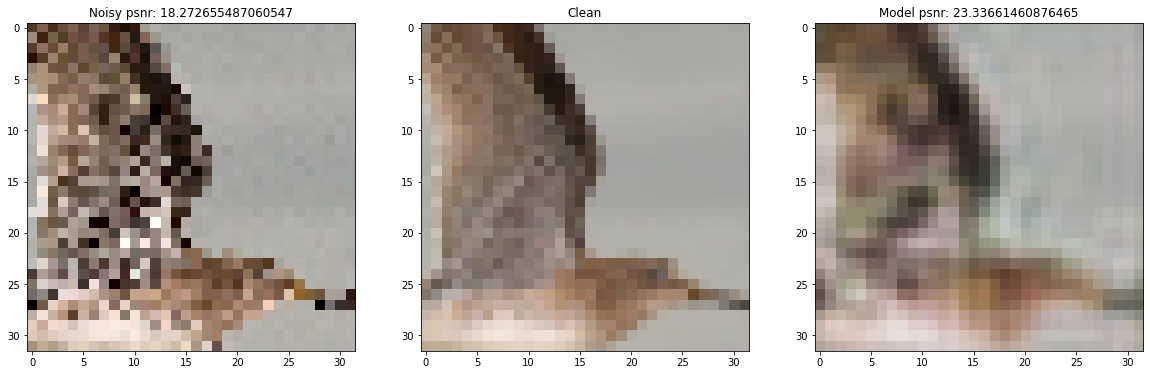

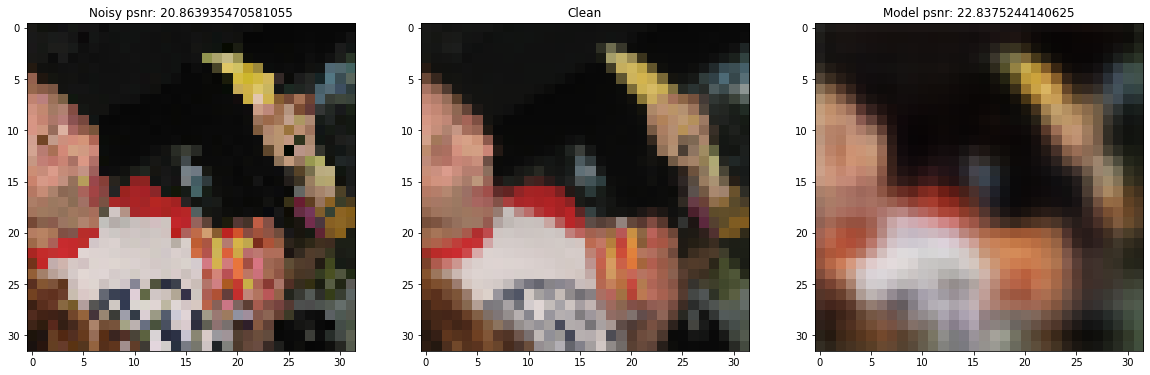

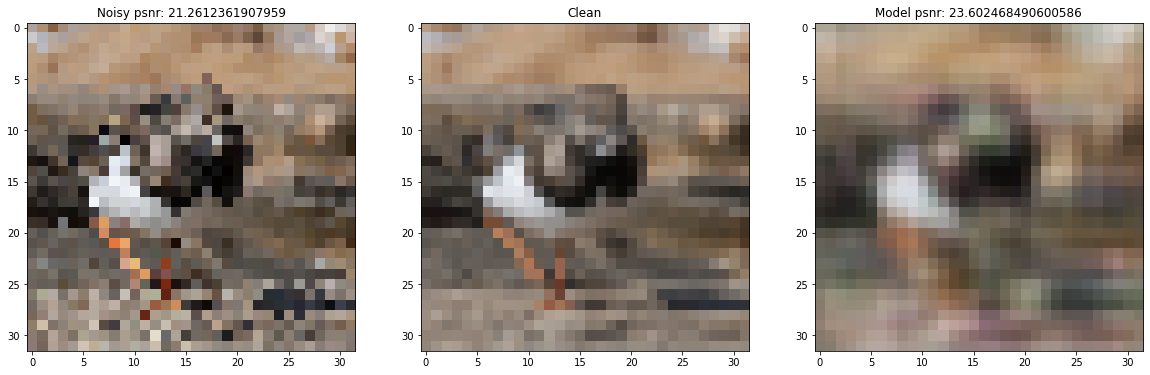

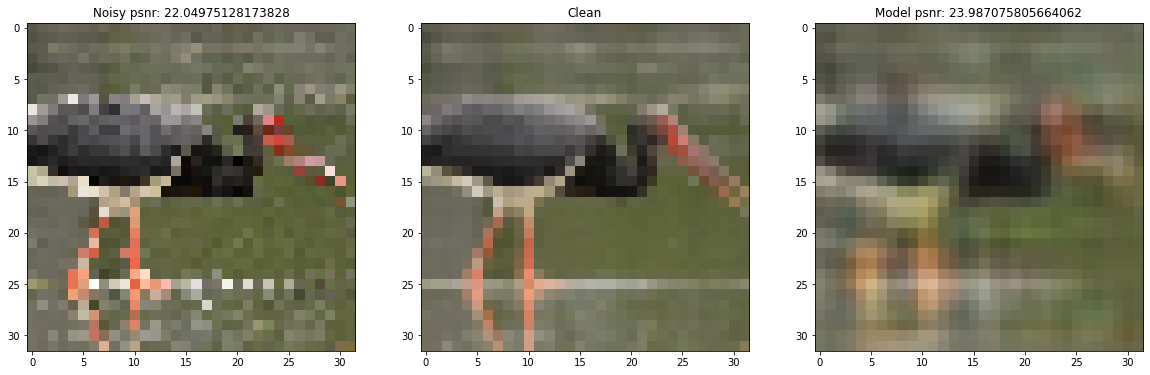

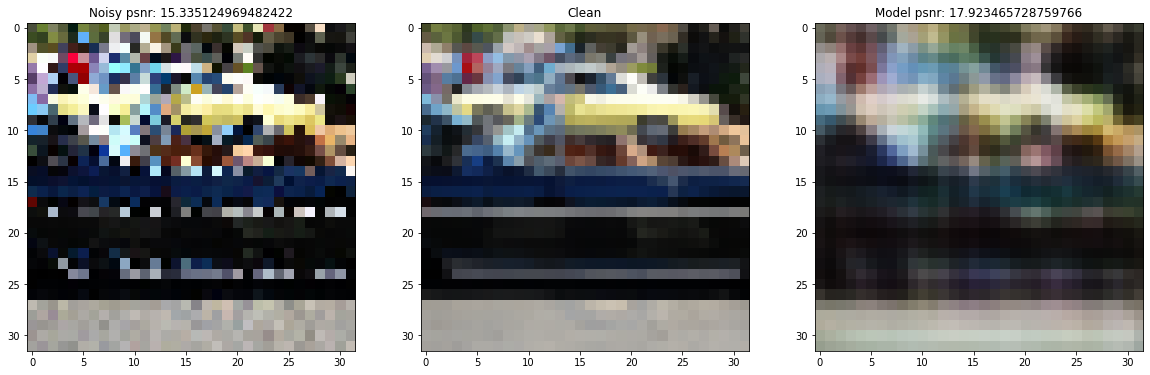

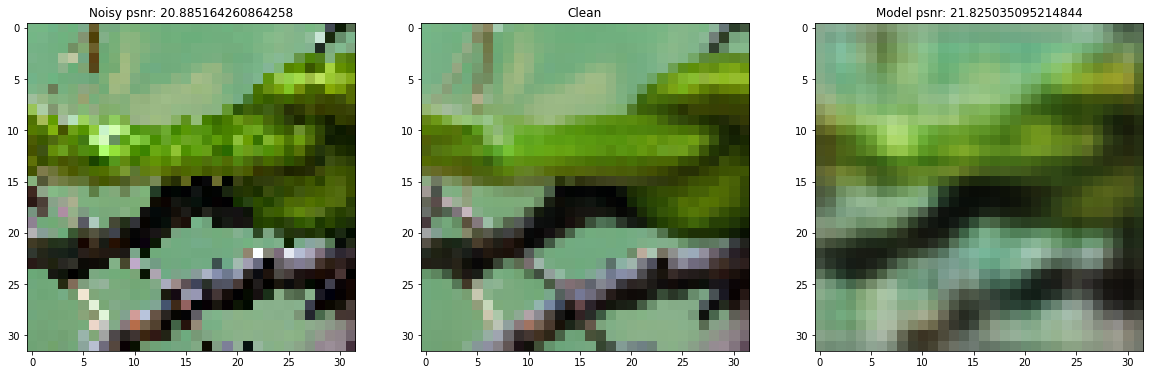

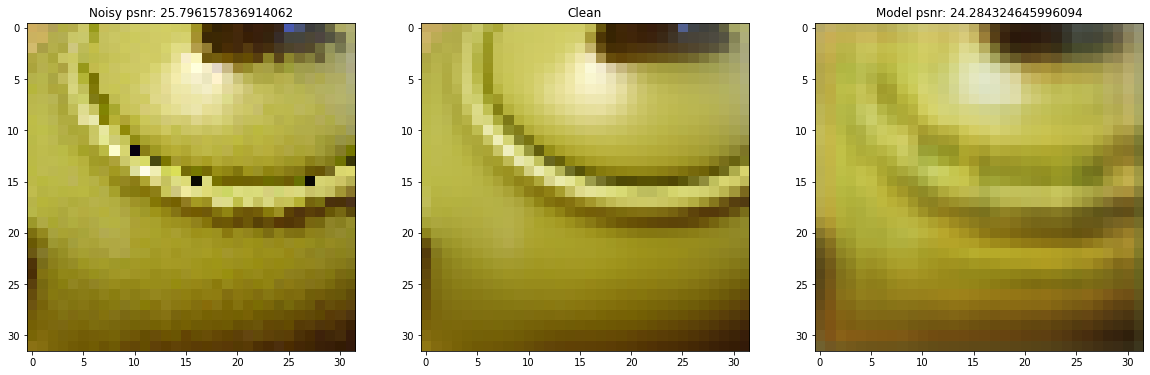

In [91]:

for i in range(30, 210, 20):
    image_number = i

    fig, axs = plt.subplots(1, 3, figsize=(20,800))
    axs[0].imshow((np.squeeze(val_noisy[image_number].int().cpu().permute(1 , 2 , 0 ))))
    axs[0].set_title("Noisy psnr: {}".format(psnr(val_noisy[image_number].float().view(1, 3, 32, 32), val_clean[image_number].view(1, 3, 32, 32), max_range=255)))
    axs[1].imshow(  (np.squeeze(val_clean[image_number].int().rot90(2, [1,2]).rot90(-2, [1,2]).cpu().permute(1 , 2 , 0 ))))
    axs[1].set_title("Clean")
    axs[2].imshow((np.squeeze(model(val_noisy[image_number].float().view(1, 3, 32, 32)).float().detach().view(3, 32, 32).cpu().permute(1 , 2 , 0 ))))
    axs[2].set_title("Model psnr: {}".format(psnr(model(val_noisy[image_number].view(1, 3, 32, 32)) * 255, val_clean[image_number].view(1, 3, 32, 32), max_range=255)))

    